# Problem B: Effective thermal conductivity of 2-phase materials
Predicting the effective thermal conductivity $k_{\text{eff}}$ of a two-phase composite material is a classical and practical problem in materials science. The goal is to estimate the bulk conductivity of a heterogeneous material made of two constituents with thermal conductivities $k_1$ and $k_2$. One efficient way to compute the effective thermal conductivity of given 2-phase materials is through numerical homogenization.

In numerical homogenization, we need to solve the steady-state heat equation on a representative volume element (RVE): 
$$
-\nabla\cdot(k(x,y)\nabla T) = 0,\quad (x,y)\in\Omega=[0,1]^2 \tag{2}
$$
With the following boundary conditions:
  - $T(x=0,y)=0,\ T(x=1,y)=1 $
  - $\frac{\partial T}{\partial \vec{n}}(x,y=0)=\frac{\partial T}{\partial \vec{n}}(x,y=1)=0$

where $T(x,y)$ indicates the temperature  and $k(x,y)$ indicates thermal conductivity, which is defined piecewise:
$$
k(x,y)=
\begin{cases}
k_1=2.,\quad (x,y)\in\Omega_1\\
k_2=10.,\quad (x,y)\in\Omega_2
\end{cases}
$$
where $\Omega_1$, $\Omega_2$ denote the first phase region and the second phase region, respectively.

<!-- To compute the effective thermal conductivity in the $x$-direction, one can follow the steps:
- **Step 1:** Solve the following PDE:
    $$
    -\nabla\cdot(k(x,y)\nabla T) = 0,\quad (x,y)\in\Omega=[0,1]^2 \tag{3}
    $$
  With boundary conditions:
  - $T(x=0,y)=0,\ T(x=1,y)=1 $
  - $\frac{\partial T}{\partial \vec{n}}(x,y=0)=\frac{\partial T}{\partial \vec{n}}(x,y=1)=0$ 
- **Step 2:** Compute the **average heat flux:**
    $$
    <q> = \frac{1}{|\Omega|}\int_{\Omega}q~d\Omega
    $$
  where $q(x,y)=-k(x,y)\partial_x T$, and the **average temperature gradient:**
    $$
    <\partial_x T> =  \frac{1}{|\Omega|}\int_{\Omega}\partial_x T~d\Omega
    $$
- **Step 3:** Compute the **effective thermal conductivity (in $x$-direction):**
    $$
    k_{eff} = -\frac{<q>}{<\partial_x T>} = \frac{<k(x,y)\partial_x T>}{<\partial_x T>}
    $$ -->

## Task: predicting the temperature field $T(x,y)$ given 2-phase material $k(x,y)$ 
In this task, we have collected many materials $k(x,y)$ which are sampled from a distribution $\mathcal{A}$. We have also computed the corresponding temperature field $T(x,y)$ through solving the PDE problem $(2)$ with high-precision FEM method. Now, we hope to make a fast prediction of the temperature field $T(x,y)$ (therefore, a fast prediction of the effective conductivity) of a group of materials that are sampled from the same distribution.

### The goals
- Please select a suitable deep learning method for solving this task, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve (and report the final error). The $L^2$ relative error between the prediction $\{T^{(j)}_{pred}\}^{N}_{j}$ and the truth $\{T^{(j)}_{true}\}^{N}_j$ is defined as follows:
  $$error = \frac{1}{N}\sum_j\sqrt{\frac{\sum_i|T^{(j)}_{pred}(x_i)-T^{(j)}_{true}(x_i)|^2}{\sum_i|T^{(j)}_{true}(x_i)|^2}}$$
 where $j$ indicates the $j$-th instance.
- Plot the material thermal conductivity, the corresponding predicted solution (and the ground truth reference), and the pointwise absolute error for the first instance in the testing Dataset using separate figures with ```matplotlib```.

### Dataset
The observation and the ground truth references are given in the dataset ```EffectiveConductivity.h5```:
- ```k_train```: size(1000, 36, 36), the collected materials (a $36\times 36$ matrix represents each material)
- ```T_train```: size(1000, 36, 36), the collected temperature field (computed on a $36\times 36$ regular mesh)
- ```k_test```: the materials that we are going to predict their corresponding temperature field (Should not be used for training)
- ```T_test```: the ground truth reference of the temperature field (Should not be used for training)
- ```X```: size(36, 36), the $x$-coordiante of locations where the temperature field computed
- ```Y```: size(36, 36), the $y$-coordiante of locations where the temperature field computed
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/dno4pdes](https://www.kaggle.com/datasets/yhzang32/dno4pdes)

<KeysViewHDF5 ['T_test', 'T_train', 'X', 'Y', 'dTx_test', 'dTx_train', 'k_test', 'k_train']>
The shape of X: torch.Size([36, 36]) The shape of Y: torch.Size([36, 36])
The shape of k_train: torch.Size([1000, 36, 36])
The shape of T_train: torch.Size([1000, 36, 36])
The shape of k_test: torch.Size([200, 36, 36])
The shape of T_test: torch.Size([200, 36, 36])


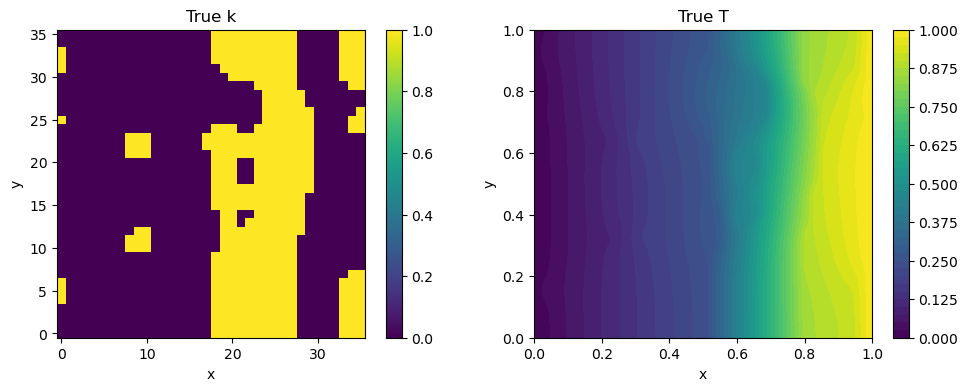

The shape of k_input: torch.Size([1000, 36, 36, 1])
The shape of T_target: torch.Size([1000, 36, 36, 1])
The shape of X: torch.Size([1000, 36, 36, 1])
The shape of Y: torch.Size([1000, 36, 36, 1])
Input tensor shape: torch.Size([1000, 36, 36, 3])


In [37]:
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
device = 'cpu'
dtype = torch.float32
######################################
# Load training data
######################################
with h5py.File('2nd_task/EffectiveConductivity.h5', 'r') as data:
    print(data.keys())
    k_train = torch.tensor(np.array(data["k_train"]), dtype=dtype)
    k_train[k_train==0]=2.
    k_train[k_train==1]=10.
    k_train = (k_train - 2.0) / 8.0 # Normalising k_train to [0,1]

    T_train = torch.tensor(np.array(data["T_train"]), dtype=dtype)

    k_test = torch.tensor(np.array(data["k_test"]), dtype=dtype)
    k_test[k_test == 0] = 2.
    k_test[k_test == 1] = 10.
    k_test = (k_test - 2.0) / 8.0 # Normalising k_tet to [0,1]

    T_test =torch.tensor( np.array(data["T_test"]), dtype=dtype)
    # The coordinates
    X = torch.tensor(np.array(data['X']), dtype=dtype)
    Y = torch.tensor(np.array(data['Y']), dtype=dtype)
print('The shape of X:', X.shape, 'The shape of Y:', Y.shape)
print('The shape of k_train:', k_train.shape)
print('The shape of T_train:', T_train.shape)
print('The shape of k_test:', k_test.shape)
print('The shape of T_test:', T_test.shape)

####### Visualize the training data 
k_show, T_show = k_train[0], T_train[0]
#
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
#
cntr0 = axs.flat[:][0].imshow(k_show, origin='lower')
fig.colorbar(cntr0, ax=axs.flat[:][0])
axs.flat[:][0].set_title('True k')
axs.flat[:][0].set_xlabel('x')
axs.flat[:][0].set_ylabel('y')
#
cntr1 = axs.flat[:][1].contourf(X, Y, T_show, levels=40)
fig.colorbar(cntr1, ax=axs.flat[:][1])
axs.flat[:][1].set_title('True T')
axs.flat[:][1].set_xlabel('x')
axs.flat[:][1].set_ylabel('y')
#
plt.show()

## Changing shapes of variables to input them to FNO architecture
k_train_unsquezed = k_train.unsqueeze(-1)  # shape: (1000, 36, 36, 1)
T_train_unsquezed = T_train.unsqueeze(-1)  # shape : (1000, 36, 36, 1)
X_batched = X.unsqueeze(0).repeat(k_train.shape[0], 1, 1)  # shape: (1000, 36, 36)
Y_batched = Y.unsqueeze(0).repeat(k_train.shape[0], 1, 1)  # shape: (1000, 36, 36)

X_unsquezzed = X_batched.unsqueeze(-1)  # shape: (1000, 36, 36, 1)
Y_unsquezzed = Y_batched.unsqueeze(-1) # shape: (1000, 36, 36, 1)
#print('The shape of grid_points:', grid_points.shape)
print('The shape of k_input:', k_train_unsquezed.shape)
print('The shape of T_target:', T_train_unsquezed.shape)
print('The shape of X:', X_unsquezzed.shape)
print('The shape of Y:', Y_unsquezzed.shape)

input_tensor = torch.cat([k_train_unsquezed, X_unsquezzed, Y_unsquezzed ], dim=-1) #shape: (1000, 36, 36, 3)
print("Input tensor shape:", input_tensor.shape)



## FNO architecture

In [38]:
import torch.nn as nn

class SpectralConv2d(nn.Module):
    
    def __init__(self, in_size, out_size, modes1, modes2, dtype):
        super(SpectralConv2d, self).__init__()
        '''2D Fourier layer: FFT -> linear transform -> Inverse FFT
        '''
        self.in_size = in_size 
        self.out_size = out_size 
        self.modes1 = modes1
        self.modes2 = modes2 
        #
        self.scale = 1./(in_size * out_size)
        #
        if (dtype is None) or (dtype==torch.float32):
            ctype = torch.complex64 
        elif (dtype==torch.float64):
            ctype = torch.complex128 
        else:
            raise TypeError(f'No such data type.')
        #
        self.weight1 = nn.Parameter(self.scale * torch.rand(in_size, out_size, 
                                                            modes1, modes2, 
                                                            dtype=ctype))
        self.weight2 = nn.Parameter(self.scale * torch.rand(in_size, out_size, 
                                                            modes1, modes2, 
                                                            dtype=ctype))
    
    def compl_mul_2d(self, input, weights):
        '''Complex multiplication: (batch_size, in_size, m1, m2) * (in_size, out_size, m1, m2) -> (batch_size, out_size, m1, m2)
        '''
        return torch.einsum('bixy,ioxy->boxy', input, weights)

    def forward(self, x):
        '''
        Input:
            x: size(batch_size, in_size, my_size, mx_size)
        Return:
            x: size(batch_size, out_size, my_size, mx_size)
        '''
        batch_size = x.shape[0]
        ####################### Compute Fourier coefficients up to factor of e^{-c}
        x_ft = torch.fft.rfft2(x) # size(batch_size, in_size, mx_size, my_size//2+1)
        ######################## Multiply relevant Fourier modes
        out_ft = torch.zeros(batch_size, self.out_size, x.size(-2), x.size(-1)//2+1, 
                             device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1, :self.modes2] \
            = self.compl_mul_2d(x_ft[:, :, :self.modes1, :self.modes2], self.weight1)
        out_ft[:, :, -self.modes1:, :self.modes2] \
            = self.compl_mul_2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weight2)
        ######################### Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1))) # size(batch_size, out_size, mx_size, my_size)

        return x 
        
class FNO2d(nn.Module):

    def __init__(self, in_size:int, out_size:int, modes1:int, modes2:int, 
                 hidden_list:list[int], dtype=None):
        super(FNO2d, self).__init__()
        self.hidden_list = hidden_list
        # Activation
        self.activation = nn.ReLU()
        # The input layer: 
        self.fc_in = nn.Linear(in_size, hidden_list[0], dtype=dtype)
        # The hidden layer
        conv_net, w_net = [], []
        self.hidden_in = hidden_list[0]
        for hidden in hidden_list:
            conv_net.append(SpectralConv2d(self.hidden_in, hidden, modes1, modes2, dtype))
            w_net.append(nn.Conv1d(self.hidden_in, hidden, 1, dtype=dtype))
            self.hidden_in =  hidden 
        self.spectral_conv = nn.Sequential(*conv_net)
        self.weight_conv = nn.Sequential(*w_net)
        # The output layer
        self.fc_out0 = nn.Linear(self.hidden_in, 128, dtype=dtype)
        self.fc_out1 = nn.Linear(128, out_size, dtype=dtype)
    
    def forward(self, ax):
        '''
        Input: 
            ax: size(batch_size, my_size, mx_size, a_size+x_size)
        Output: 
            u: size(batch_size, my_size, mx_size, out_size)
        '''
        batch_size = ax.shape[0]
        mx_size, my_size = ax.shape[1], ax.shape[2]
        # The input layer: size(b, mx_size, my_size, in_size) -> (b, hidden_size, my_size, mx_size)
        ax = self.fc_in(ax)
        ax = ax.permute(0, 3, 1, 2)
        # The spectral conv layer 
        for conv, weight, hidden_size in zip(self.spectral_conv, self.weight_conv, self.hidden_list):
            ax1 = conv(ax)   # size(b, hidden_size, my_size, mx_size)
            ax2 = weight(ax.view(batch_size, hidden_size, -1)).view(batch_size, hidden_size, mx_size, my_size)
            ax = self.activation(ax1+ax2)
        # The output layer: size(batch_size, hidden_size, my_size, mx_size) -> size(batch_size, my_size, mx_size, out_size)
        ax = ax.permute(0, 2, 3, 1)
        ax = self.fc_out0(ax)
        ax = self.activation(ax)

        return self.fc_out1(ax)
#
mode1, mode2 = 8, 8     # Number of retained low-frequency Fourier modes
hidden_list = [40, 40, 40]      # Number of feature channels in each spectral convolution block

model_u = FNO2d(input_tensor.shape[-1], T_train_unsquezed.shape[-1], mode1, mode2, hidden_list).to(device) # FNO2d (3, 1, 8, 8, hidden_list)
################## Find total trainable parameters
total_trainable_params = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

624,857 training parameters.


## Loss class

In [39]:
class LossClass(object):

    def __init__(self, u_model):
        self.device = device
        self.u_model = u_model 
    
    def loss_data(self, input_tensor, T_train):
        '''loss term'''
        batch_size = T_train.shape[0]
        input, T = input_tensor.to(self.device), T_train.to(self.device)
        #
        u_pred = self.u_model(input)
        loss = torch.norm(T.reshape(batch_size, -1)-u_pred.reshape(batch_size, -1), 2, 1)
        loss = torch.mean(loss)
        
        return loss 

## Creating Dataset class and Dataloader

In [40]:
from torch.utils.data import Dataset, DataLoader
############# Define your own dataset 
class MyDataset(Dataset):

    def __init__(self, ax:torch.tensor, u:torch.tensor):
        '''
        Input:
            ax: size(batch_size, a_size+x_size)
            u: size(batch_size, u_size)
        '''
        self.ax = ax
        self.u = u
    
    def __getitem__(self, index):
        return self.ax[index], self.u[index]

    def __len__(self):
        return self.ax.shape[0]
        
##############
train_loader = DataLoader(MyDataset(input_tensor, T_train_unsquezed), batch_size=50, shuffle=True)

for k_input, T_target in train_loader:
    print('k_input:', k_input.shape, 'T_target:', T_target.shape)

k_input: torch.Size([50, 36, 36, 3]) T_target: torch.Size([50, 36, 36, 1])
k_input: torch.Size([50, 36, 36, 3]) T_target: torch.Size([50, 36, 36, 1])
k_input: torch.Size([50, 36, 36, 3]) T_target: torch.Size([50, 36, 36, 1])
k_input: torch.Size([50, 36, 36, 3]) T_target: torch.Size([50, 36, 36, 1])
k_input: torch.Size([50, 36, 36, 3]) T_target: torch.Size([50, 36, 36, 1])
k_input: torch.Size([50, 36, 36, 3]) T_target: torch.Size([50, 36, 36, 1])
k_input: torch.Size([50, 36, 36, 3]) T_target: torch.Size([50, 36, 36, 1])
k_input: torch.Size([50, 36, 36, 3]) T_target: torch.Size([50, 36, 36, 1])
k_input: torch.Size([50, 36, 36, 3]) T_target: torch.Size([50, 36, 36, 1])
k_input: torch.Size([50, 36, 36, 3]) T_target: torch.Size([50, 36, 36, 1])
k_input: torch.Size([50, 36, 36, 3]) T_target: torch.Size([50, 36, 36, 1])
k_input: torch.Size([50, 36, 36, 3]) T_target: torch.Size([50, 36, 36, 1])
k_input: torch.Size([50, 36, 36, 3]) T_target: torch.Size([50, 36, 36, 1])
k_input: torch.Size([50, 

## Running training and evaluating L2 relative error

In [41]:
from tqdm import trange
import time
############ Training setups
epochs = 200
lr = 1e-3
optimizer = torch.optim.Adam(params=model_u.parameters(), lr=lr, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/4), gamma=0.5)
loss_list = []
test_l2_list = []
############ The training process
lossClass = LossClass(model_u)

with h5py.File('2nd_task/EffectiveConductivity.h5', 'r') as data_test:
    print(data_test.keys())  
    k_test = torch.tensor(np.array(data_test["k_test"]), dtype=dtype)
    k_test[k_test==0]=2.
    k_test[k_test==1]=10.
    k_test = (k_test - 2.0) / 8.0
    T_test =torch.tensor( np.array(data_test["T_test"]), dtype=dtype)
    X = torch.tensor(np.array(data_test['X']), dtype=dtype)
    Y = torch.tensor(np.array(data_test['Y']), dtype=dtype)
print('The shape of a_test:', k_test.shape)
print('The shape of uT_test:', T_test.shape)
print('X:', X.shape)
print('Y:', Y.shape)
#######################################
# The L2 relative error
#######################################
def L2_error(T_true, T_pred):
    ''' '''
    l2 = torch.norm(T_true_flat - T_pred_flat, dim=1) / (torch.norm(T_true_flat, dim=1) + 1e-8)
    return l2
# Make prediction with trained model
k_test_unsquezed = k_test.unsqueeze(-1)  # shape: (1000, 36, 36, 1)
T_test_unsquezed = T_test.unsqueeze(-1)  # shape : (1000, 36, 36, 1)
X_batched = X.unsqueeze(0).repeat(k_test.shape[0], 1, 1)  # shape: (1000, 36, 36)
Y_batched = Y.unsqueeze(0).repeat(k_test.shape[0], 1, 1)  # shape: (1000, 36, 36)

X_unsquezzed = X_batched.unsqueeze(-1)  # shape: (1000, 36, 36, 1)
Y_unsquezzed = Y_batched.unsqueeze(-1) # shape: (1000, 36, 36, 1)
#print('The shape of grid_points:', grid_points.shape)
print('The shape of k_input:', k_test_unsquezed.shape)
print('The shape of T_target:', T_test_unsquezed.shape)
print('The shape of X:', X_unsquezzed.shape)
print('The shape of Y:', Y_unsquezzed.shape)

test_tensor = torch.cat([k_test_unsquezed, X_unsquezzed, Y_unsquezzed ], dim=-1)
print("Input tensor shape:", test_tensor.shape)


with torch.no_grad():
    T_test_pred = model_u(test_tensor.to(device)).cpu()

T_true_flat = T_test_unsquezed.reshape(T_test_unsquezed.shape[0], -1)
T_pred_flat = T_test_pred.reshape(T_test_pred.shape[0], -1)

print('The shape of uT_pred:', T_test_pred.shape)

t0 = time.time()
for epoch in trange(epochs):
    loss = 0.
    for k_input, T_train in train_loader:
        k_input = k_input.to(device)
        T_train = T_train.to(device)

        loss_train = lossClass.loss_data(k_input, T_train)
        #
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        #
        loss += loss_train
    #
    scheduler.step()  # Adjust learning rate
    loss = loss/len(train_loader)
    loss_list.append(loss.item())
    if (epoch+1)%25==0:
        print(f'Epoch:{epoch}, The loss is:{loss.item()}')
    
    # Evaluate on test set every epoch
    with torch.no_grad():
        T_test_pred = model_u(test_tensor.to(device)).cpu()
        T_pred_flat = T_test_pred.view(T_test_pred.shape[0], -1)
        T_true_flat = T_test_unsquezed.view(T_test_unsquezed.shape[0], -1)
        l2_test_error = L2_error(T_true_flat, T_pred_flat)
        test_l2_list.append(torch.mean(l2_test_error).item())

print('The consuming time is:', time.time()-t0)

<KeysViewHDF5 ['T_test', 'T_train', 'X', 'Y', 'dTx_test', 'dTx_train', 'k_test', 'k_train']>
The shape of a_test: torch.Size([200, 36, 36])
The shape of uT_test: torch.Size([200, 36, 36])
X: torch.Size([36, 36])
Y: torch.Size([36, 36])
The shape of k_input: torch.Size([200, 36, 36, 1])
The shape of T_target: torch.Size([200, 36, 36, 1])
The shape of X: torch.Size([200, 36, 36, 1])
The shape of Y: torch.Size([200, 36, 36, 1])
Input tensor shape: torch.Size([200, 36, 36, 3])
The shape of uT_pred: torch.Size([200, 36, 36, 1])


 12%|█▏        | 24/200 [03:10<22:21,  7.62s/it]

Epoch:24, The loss is:0.308582603931427


 24%|██▍       | 49/200 [06:21<20:21,  8.09s/it]

Epoch:49, The loss is:0.36688700318336487


 37%|███▋      | 74/200 [09:40<15:57,  7.60s/it]

Epoch:74, The loss is:0.20630225539207458


 50%|████▉     | 99/200 [13:23<15:25,  9.16s/it]

Epoch:99, The loss is:0.18987098336219788


 62%|██████▏   | 124/200 [16:38<10:12,  8.06s/it]

Epoch:124, The loss is:0.1763121783733368


 74%|███████▍  | 149/200 [20:08<07:01,  8.26s/it]

Epoch:149, The loss is:0.1609148532152176


 87%|████████▋ | 174/200 [23:32<03:49,  8.82s/it]

Epoch:174, The loss is:0.15287765860557556


100%|█████████▉| 199/200 [26:58<00:07,  7.89s/it]

Epoch:199, The loss is:0.14988353848457336


100%|██████████| 200/200 [27:06<00:00,  8.13s/it]

The consuming time is: 1626.2707426548004


## Plotting results

The l2 error: tensor([0.0122, 0.0112, 0.0125, 0.0077, 0.0137, 0.0090, 0.0065, 0.0091, 0.0095,
        0.0081, 0.0070, 0.0104, 0.0086, 0.0078, 0.0069, 0.0095, 0.0101, 0.0071,
        0.0094, 0.0094, 0.0083, 0.0150, 0.0097, 0.0077, 0.0082, 0.0079, 0.0080,
        0.0086, 0.0087, 0.0084, 0.0090, 0.0120, 0.0062, 0.0072, 0.0107, 0.0094,
        0.0121, 0.0077, 0.0165, 0.0114, 0.0114, 0.0070, 0.0084, 0.0085, 0.0073,
        0.0130, 0.0066, 0.0097, 0.0074, 0.0053, 0.0084, 0.0070, 0.0093, 0.0107,
        0.0118, 0.0187, 0.0147, 0.0079, 0.0067, 0.0093, 0.0059, 0.0076, 0.0052,
        0.0084, 0.0089, 0.0140, 0.0072, 0.0109, 0.0080, 0.0080, 0.0064, 0.0078,
        0.0083, 0.0070, 0.0094, 0.0132, 0.0070, 0.0082, 0.0120, 0.0100, 0.0076,
        0.0170, 0.0060, 0.0133, 0.0092, 0.0078, 0.0105, 0.0084, 0.0074, 0.0077,
        0.0071, 0.0104, 0.0101, 0.0074, 0.0060, 0.0134, 0.0103, 0.0093, 0.0085,
        0.0104, 0.0195, 0.0070, 0.0142, 0.0076, 0.0069, 0.0109, 0.0075, 0.0080,
        0.0078, 0.0076, 0.

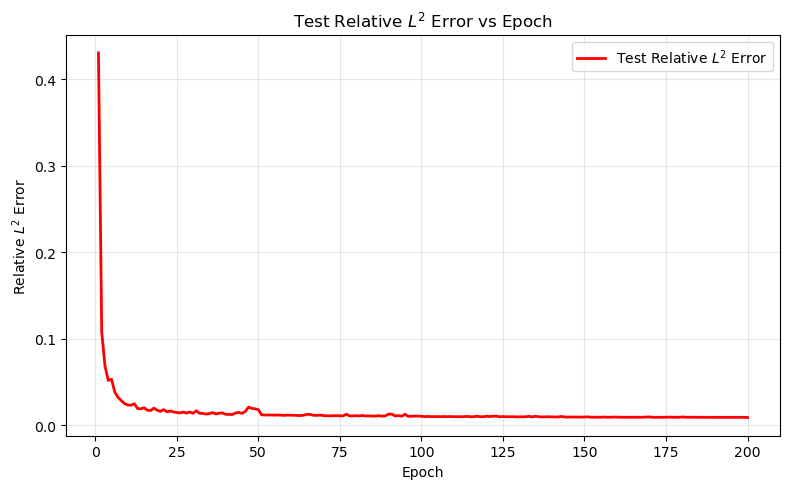

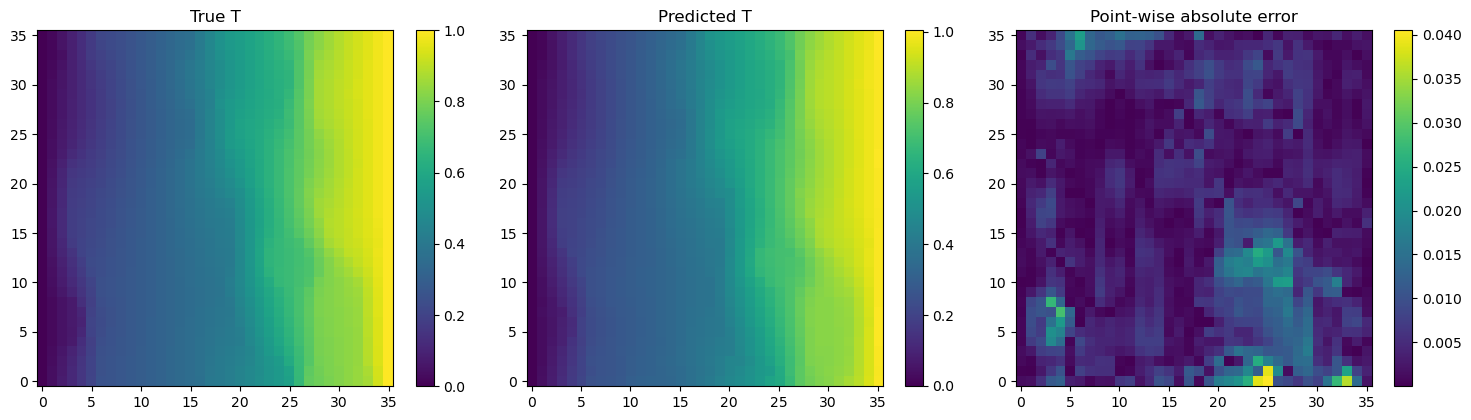

In [42]:
# compute the L2 relative error
l2_err = L2_error(T_true_flat, T_pred_flat)

print('The l2 error:', l2_err)
print('The average l2 error:', torch.mean(l2_err))

#######################################
# Visualize the prediction and truth u
#######################################
# Visualize

# Plotting L2 error
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), test_l2_list, 'r-', linewidth=2, label='Test Relative $L^2$ Error')
plt.xlabel('Epoch')
plt.ylabel('Relative $L^2$ Error')
plt.title('Test Relative $L^2$ Error vs Epoch')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


inx = 0
uT_true = T_test_unsquezed[inx, :, :, 0]
uT_pred = T_test_pred[inx, :, :, 0]

error_map = torch.abs(uT_true - uT_pred)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

im0 = axs[0].imshow(uT_true, origin='lower')
axs[0].set_title('True T')
fig.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(uT_pred, origin='lower')
axs[1].set_title('Predicted T')
fig.colorbar(im1, ax=axs[1])

im2 = axs[2].imshow(error_map, origin='lower')
axs[2].set_title('Point-wise absolute error')
fig.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.show()

## DeepOnet architecture

<KeysViewHDF5 ['T_test', 'T_train', 'X', 'Y', 'dTx_test', 'dTx_train', 'k_test', 'k_train']>
The shape of X: torch.Size([36, 36]) The shape of Y: torch.Size([36, 36])
The shape of k_train: torch.Size([1000, 36, 36])
The shape of T_train: torch.Size([1000, 36, 36])
The shape of k_test: torch.Size([200, 36, 36])
The shape of T_test: torch.Size([200, 36, 36])


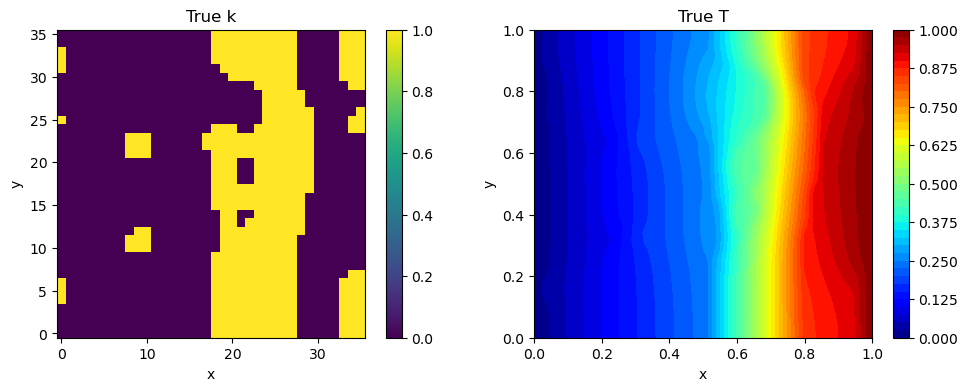

The shape of k_input: torch.Size([1000, 36, 36, 1])
The shape of T_target: torch.Size([1000, 36, 36, 1])
The shape of X: torch.Size([1000, 36, 36, 1])
The shape of Y: torch.Size([1000, 36, 36, 1])
Input tensor shape: torch.Size([1000, 36, 36, 3])


In [43]:
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
device = 'cpu'
dtype = torch.float32
######################################
# Load training data
######################################
with h5py.File('2nd_task/EffectiveConductivity.h5', 'r') as data:
    print(data.keys())
    k_train = torch.tensor(np.array(data["k_train"]), dtype=dtype)
    k_train[k_train==0]=2.
    k_train[k_train==1]=10.
    k_train = (k_train - 2.0) / 8.0 # Normalising k_train to [0,1]

    T_train = torch.tensor(np.array(data["T_train"]), dtype=dtype)

    k_test = torch.tensor(np.array(data["k_test"]), dtype=dtype)
    k_test[k_test == 0] = 2.
    k_test[k_test == 1] = 10.
    k_test = (k_test - 2.0) / 8.0 # Normalising k_tet to [0,1]

    T_test =torch.tensor( np.array(data["T_test"]), dtype=dtype)
    # The coordinates
    X = torch.tensor(np.array(data['X']), dtype=dtype)
    Y = torch.tensor(np.array(data['Y']), dtype=dtype)
print('The shape of X:', X.shape, 'The shape of Y:', Y.shape)
print('The shape of k_train:', k_train.shape)
print('The shape of T_train:', T_train.shape)
print('The shape of k_test:', k_test.shape)
print('The shape of T_test:', T_test.shape)

####### Visualize the training data 
k_show, T_show = k_train[0], T_train[0]
#
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
#
cntr0 = axs.flat[:][0].imshow(k_show, origin='lower')
fig.colorbar(cntr0, ax=axs.flat[:][0])
axs.flat[:][0].set_title('True k')
axs.flat[:][0].set_xlabel('x')
axs.flat[:][0].set_ylabel('y')
#
cntr1 = axs.flat[:][1].contourf(X, Y, T_show, levels=40, cmap='jet')
fig.colorbar(cntr1, ax=axs.flat[:][1])
axs.flat[:][1].set_title('True T')
axs.flat[:][1].set_xlabel('x')
axs.flat[:][1].set_ylabel('y')
#
plt.show()

## Changing shapes of variables to input them to FNO architecture
k_train_unsquezed = k_train.unsqueeze(-1)  # shape: (1000, 36, 36, 1)
T_train_unsquezed = T_train.unsqueeze(-1)  # shape : (1000, 36, 36, 1)
X_batched = X.unsqueeze(0).repeat(k_train.shape[0], 1, 1)  # shape: (1000, 36, 36)
Y_batched = Y.unsqueeze(0).repeat(k_train.shape[0], 1, 1)  # shape: (1000, 36, 36)

X_unsquezzed = X_batched.unsqueeze(-1)  # shape: (1000, 36, 36, 1)
Y_unsquezzed = Y_batched.unsqueeze(-1) # shape: (1000, 36, 36, 1)
#print('The shape of grid_points:', grid_points.shape)
print('The shape of k_input:', k_train_unsquezed.shape)
print('The shape of T_target:', T_train_unsquezed.shape)
print('The shape of X:', X_unsquezzed.shape)
print('The shape of Y:', Y_unsquezzed.shape)

input_tensor = torch.cat([k_train_unsquezed, X_unsquezzed, Y_unsquezzed ], dim=-1) #shape: (1000, 36, 36, 3)
print("Input tensor shape:", input_tensor.shape)



## DeepOnet model

In [44]:
import torch.nn as nn
#
class DeepONet(nn.Module):
    
    def __init__(self, layers_trunk, layers_branch, branch_type=None):
        super(DeepONet, self).__init__()
        # The trunk network
        self.activation_trunk = nn.ReLU()
        self.trunk_net(layers_trunk)
        
        # The branch network
        self.activation_branch = nn.ReLU()
        self.branch_net_mlp(layers_branch)
            
        # The bias term
        self.bias = torch.nn.Parameter(torch.tensor(0.0, dtype=dtype))

    def branch_net_mlp(self, layers_branch):
        '''The branch network (MLP network)'''
        # Network Sequential
        net = []
        hidden_in = layers_branch[0]
        for hidden in layers_branch[1:]:
            net.append(nn.Linear(hidden_in, hidden, dtype=dtype))
            net.append(self.activation_branch)
            hidden_in = hidden
        self.branch = nn.Sequential(*net)
        
    def trunk_net(self, layers_trunk):
        '''The trunk network'''
        # Network Sequential
        net = []
        hidden_in = layers_trunk[0]
        for hidden in layers_trunk[1:]:
            net.append(nn.Linear(hidden_in, hidden, dtype=dtype))
            net.append(self.activation_trunk)
            hidden_in = hidden
        self.trunk = nn.Sequential(*net)
        
    def forward(self, grid_points, k_input):
        ''' 
        Input:
            x: size(mesh_size, x_size)
            a: size(batch_size, a_size)
        '''
        # size(mesh_size, x_size) -> size(mesh_size, p)
        trunk_output = self.trunk(grid_points)
        # size(batch_size, a_size) -> size(batch_size, p)
        branch_output = self.branch(k_input)
        #
        output = torch.einsum("bp,mp->bm", branch_output, trunk_output) + self.bias
        return output
#
# Flattening the data
grid_points = torch.stack([X.flatten(), Y.flatten()], dim=1).to(device)
k_input = k_train.view(k_train.shape[0], -1).to(device)
T_target = T_train.view(T_train.shape[0], -1).to(device)

print('The shape of grid_points:', grid_points.shape)
print('The shape of k_input:', k_input.shape)

layers_trunk = [grid_points.shape[-1], 256, 256, 256, 256, 256]
layers_branch = [k_input.shape[-1],  256, 256, 256, 256, 256]
#
model_T = DeepONet(layers_trunk, layers_branch).to(device)
#
from torchinfo import summary

summary(model_T, input_data=[torch.randn(1296, 2), torch.randn(1, 1296)], device='cpu')


The shape of grid_points: torch.Size([1296, 2])
The shape of k_input: torch.Size([1000, 1296])


Layer (type:depth-idx)                   Output Shape              Param #
DeepONet                                 [1, 1296]                 1
├─Sequential: 1-1                        [1296, 256]               --
│    └─Linear: 2-1                       [1296, 256]               768
│    └─ReLU: 2-2                         [1296, 256]               --
│    └─Linear: 2-3                       [1296, 256]               65,792
│    └─ReLU: 2-4                         [1296, 256]               --
│    └─Linear: 2-5                       [1296, 256]               65,792
│    └─ReLU: 2-6                         [1296, 256]               --
│    └─Linear: 2-7                       [1296, 256]               65,792
│    └─ReLU: 2-8                         [1296, 256]               --
│    └─Linear: 2-9                       [1296, 256]               65,792
│    └─ReLU: 2-10                        [1296, 256]               --
├─Sequential: 1-2                        [1, 256]                  --

## Loss function 

In [45]:
class LossClass(object):

    def __init__(self, T_model, grid_points):
        self.device = device
        self.T_model = T_model 
        self.grid_points = grid_points.to(device)

    def loss_data(self, k_batch, T_true):
        T_pred = self.T_model(self.grid_points, k_batch)
        loss = torch.norm(T_pred - T_true, 2, 1)
        loss = torch.mean(loss)
        
        return loss 

## Training loop

In [46]:
from tqdm import trange, tqdm
from torch.utils.data import Dataset, DataLoader
import time
############# Define your own dataset 
class MyDataset(Dataset):

    def __init__(self, a:torch.tensor, uT:torch.tensor):
        '''
        Input:
            a: size(batch_size, a_size)
            uT: size(batch_size, uT_size)
        '''
        self.a = a 
        self.uT = uT
    
    def __getitem__(self, index):
        return self.a[index], self.uT[index]

    def __len__(self):
        return self.a.shape[0]

print(k_train.shape)
print(T_train.shape)       
train_loader = DataLoader(MyDataset(k_train, T_train), batch_size=50, shuffle=True)

################# Training setups
epochs = 300
lr = 1e-4
optimizer = torch.optim.Adam(params=model_T.parameters(), lr=lr, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/4), gamma=0.5)
loss_list = []
t0 = time.time()
# Initialize the loss class
lossClass = LossClass(model_T, grid_points)

for epoch in tqdm(range(epochs)):
    loss = 0.
    for k_batch, T_batch in train_loader:
        k_batch = k_batch.view(k_batch.shape[0], -1).to(device)
        T_batch = T_batch.view(T_batch.shape[0], -1).to(device)
        loss_train = lossClass.loss_data(k_batch, T_batch)
        #
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        #
        loss += loss_train
    #
    scheduler.step()  # Adjust learning rate
    #
    loss = loss/len(train_loader)
    loss_list.append(loss.item())
    if (epoch+1)%100==0:
        print(f'Epoch:{epoch}, The loss is:{loss.item()}')
print('The consuming time is:', time.time()-t0)

torch.Size([1000, 36, 36])
torch.Size([1000, 36, 36])


 33%|███▎      | 100/300 [00:45<01:33,  2.14it/s]

Epoch:99, The loss is:0.793357253074646


 67%|██████▋   | 200/300 [01:29<00:45,  2.21it/s]

Epoch:199, The loss is:0.6880542039871216


100%|██████████| 300/300 [02:13<00:00,  2.24it/s]

Epoch:299, The loss is:0.6336613297462463
The consuming time is: 134.00584292411804


## Plotting the results for DeepOnet architecture

<KeysViewHDF5 ['T_test', 'T_train', 'X', 'Y', 'dTx_test', 'dTx_train', 'k_test', 'k_train']>
The shape of a_test: torch.Size([200, 36, 36])
The shape of uT_test: torch.Size([200, 36, 36])
X: torch.Size([36, 36])
Y: torch.Size([36, 36])
The shape of uT_pred: torch.Size([200, 1296])
The l2 error: tensor([0.0490, 0.0501, 0.0722, 0.0604, 0.1374, 0.0315, 0.0395, 0.0406, 0.0583,
        0.0454, 0.0304, 0.0305, 0.0523, 0.0440, 0.0306, 0.0511, 0.0532, 0.0327,
        0.0838, 0.0466, 0.0384, 0.0814, 0.0334, 0.0295, 0.0464, 0.0341, 0.0451,
        0.0304, 0.0308, 0.0427, 0.0415, 0.0500, 0.0157, 0.0306, 0.0573, 0.0495,
        0.0569, 0.0694, 0.0413, 0.0522, 0.0786, 0.0404, 0.0455, 0.0328, 0.0368,
        0.0503, 0.0381, 0.0326, 0.0532, 0.0315, 0.0318, 0.0298, 0.0434, 0.0615,
        0.0458, 0.0546, 0.0469, 0.0298, 0.0482, 0.0502, 0.0560, 0.0527, 0.0273,
        0.0434, 0.0414, 0.0599, 0.0341, 0.0398, 0.0295, 0.0327, 0.0389, 0.0434,
        0.0501, 0.0269, 0.0371, 0.0616, 0.0326, 0.0639, 0.0586, 

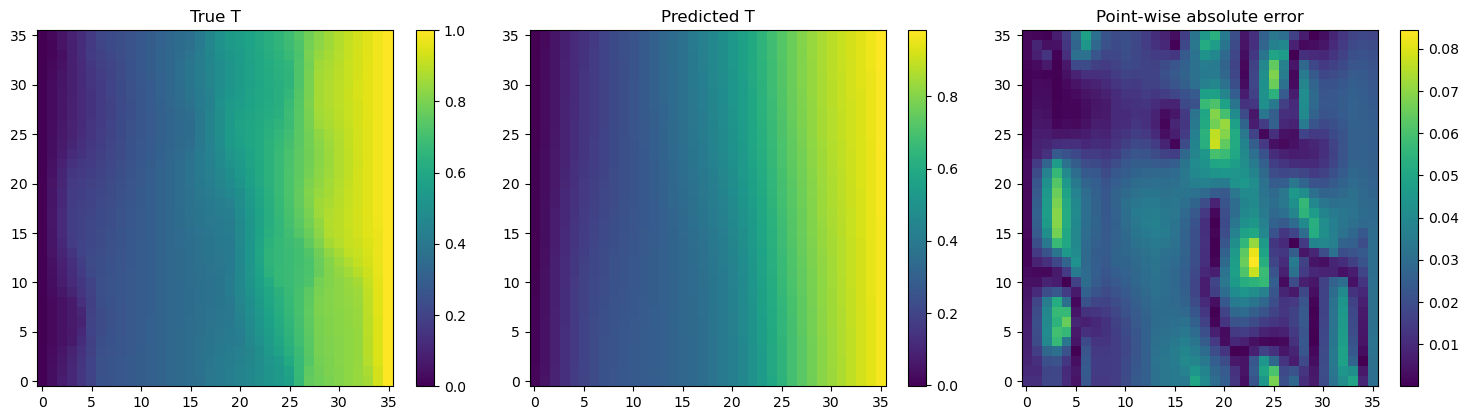

In [48]:
######################################
# Load testing data
######################################

#
with h5py.File('2nd_task/EffectiveConductivity.h5', 'r') as data_test:
    print(data_test.keys())  
    k_test = torch.tensor(np.array(data_test["k_test"]), dtype=dtype)
    k_test[k_test==0]=2.
    k_test[k_test==1]=10.
    k_test = (k_test - 2.0) / 8.0
    T_test =torch.tensor( np.array(data_test["T_test"]), dtype=dtype)
    X = torch.tensor(np.array(data_test['X']), dtype=dtype)
    Y = torch.tensor(np.array(data_test['Y']), dtype=dtype)
print('The shape of a_test:', k_test.shape)
print('The shape of uT_test:', T_test.shape)
print('X:', X.shape)
print('Y:', Y.shape)
#######################################
# The L2 relative error
#######################################
def L2_error(T_true, T_pred):
    ''' '''
    l2 = torch.norm(T_true-T_pred, 2, 1) / (torch.norm(T_true, 2, 1) + 1e-8)
    return l2
# Make prediction with trained model
grid_points = torch.stack([X.flatten(), Y.flatten()], dim=1).to(device)
k_test_flat = k_test.view(k_test.shape[0], -1).to(device)
T_test_flat = T_test.view(T_test.shape[0], -1)

T_test_pred = model_T(grid_points, k_test_flat).detach().cpu()
print('The shape of uT_pred:', T_test_pred.shape)
# compute the L2 relative error
l2_err = L2_error(T_test_flat, T_test_pred)
print('The l2 error:', l2_err)
print('The average l2 error:', torch.mean(l2_err))
#######################################
# Visualize the prediction and truth u
#######################################
# Visualize
inx = 0
uT_true = T_test[inx]
uT_pred = T_test_pred[inx].view(36, 36)

error_map = torch.abs(uT_true - uT_pred)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

im0 = axs[0].imshow(uT_true, origin='lower')
axs[0].set_title('True T')
fig.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(uT_pred, origin='lower')
axs[1].set_title('Predicted T')
fig.colorbar(im1, ax=axs[1])

im2 = axs[2].imshow(error_map, origin='lower')
axs[2].set_title('Point-wise absolute error')
fig.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.show()